#### Model Training Notebook

In this notebook, we train two ML models using the GOLD dataset:

- **Regression:** predict next-day temperature (`tmax_nextday`)  
- **Classification:** predict rain for the next day (`rain_nextday`)

Steps:
1. Load GOLD data  
2. Select features  
3. Train/test split  
4. Train models  
5. Evaluate  
6. Log models in MLflow  

In [0]:
spark.conf.set(
    "fs.azure.account.key.qatarclimateanalysis.dfs.core.windows.net",
    "<account key>"
)

In [0]:
# IMPORTING REQUIRED LIBRARIES

# Pandas & NumPy for data manipulation
import pandas as pd       # used for dataframes 
import numpy as np        # used for numerical operations

# Scikit-learn tools
from sklearn.model_selection import train_test_split  # for splitting train/test
from sklearn.metrics import (                         # evaluation metrics
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.ensemble import RandomForestRegressor     # regression model
from sklearn.ensemble import RandomForestClassifier    # classification model

# For logging models & metrics
import mlflow
import mlflow.sklearn

# Plotting libraries
import matplotlib.pyplot as plt        # basic plotting
import seaborn as sns                  # advanced/statistical plots

# Enable better plot style
sns.set_style("whitegrid")             # clean background for plots

# Make plots show inside notebook
%matplotlib inline


In [0]:
# Read gold data
gold_path = "abfss://lakehouse@qatarclimateanalysis.dfs.core.windows.net/gold/gcc_gold.parquet"
df = spark.read.parquet(gold_path)

# Convert Spark DataFrame → Pandas DataFrame
# scikit-learn works with Pandas, not Spark.
pdf = df.toPandas()

# Ensure date column is datetime format
pdf['date'] = pd.to_datetime(pdf['date'])

display(pdf.head(10))

ID,date,PRCP,TAVG,TMAX,TMIN,tmax_nextday,rain_nextday,TMAX_lag1,TMIN_lag1,PRCP_lag1,TMAX_lag2,TMAX_lag3,TAVG_lag1,PRCP_lag2,TMAX_7d_avg,TMIN_7d_avg,TAVG_7d_avg,day_of_week,month,day_of_year,TMAX_30d_avg,TMIN_30d_avg,TAVG_30d_avg,PRCP_30d_sum,PRCP_30d_avg,TMAX_30d_std,tmax_zscore,is_temp_anomaly,is_rain_anomaly,sin_day_of_year,cos_day_of_year
SAM00041112,2023-03-04T00:00:00Z,0.0,17.0,24.0,11.9,24.0,0,24.0,9.3,0.0,22.5,22.5,18.7,0.0,22.32857142857143,10.928571428571427,16.942857142857143,7,3,63,22.14333333333334,9.550000000000002,16.213333333333335,0.0,0.0,1.0287868092323962,1.8047146891900416,0,0,0.8840675099433636,0.4673592171580022
SAM00041112,2023-03-05T00:00:00Z,0.0,18.1,24.0,10.7,24.0,0,24.0,11.9,0.0,24.0,22.5,17.0,0.0,22.67142857142857,10.942857142857141,17.000000000000004,1,3,64,22.130000000000006,9.68,16.293333333333337,0.0,0.0,1.0007411046922619,1.8686151605364887,0,0,0.8919813464595485,0.45207220393230435
SAM00041112,2023-03-06T00:00:00Z,0.0,18.6,24.0,10.9,24.0,0,24.0,10.7,0.0,24.0,24.0,18.1,0.0,23.014285714285712,10.614285714285712,17.142857142857142,2,3,65,22.116666666666674,9.816666666666666,16.410000000000004,0.0,0.0,0.971697176232826,1.9381895711942099,0,0,0.8996308696522433,0.43665123195606403
SAM00041112,2023-03-07T00:00:00Z,0.0,18.6,24.0,11.8,24.0,0,24.0,10.9,0.0,24.0,24.0,18.6,0.0,23.357142857142858,10.371428571428572,17.285714285714285,3,3,66,22.10333333333334,9.833333333333332,16.536666666666672,0.0,0.0,0.9415626531915214,2.014381794177709,0,0,0.9070138128026359,0.4211008707960896
SAM00041112,2023-03-08T00:00:00Z,0.0,18.2,24.0,12.1,24.0,0,24.0,11.8,0.0,24.0,24.0,18.6,0.0,23.571428571428573,10.6,17.599999999999998,4,3,67,22.09000000000001,10.003333333333334,16.640000000000004,0.0,0.0,0.9102292246348201,2.0983725289267356,0,0,0.9141279881853337,0.40542572835999735
SAM00041112,2023-03-09T00:00:00Z,0.0,17.2,24.0,13.2,24.0,0,24.0,12.1,0.0,24.0,24.0,18.2,0.0,23.785714285714285,10.857142857142858,17.97142857142857,5,3,68,22.170000000000005,10.07,16.70666666666667,0.0,0.0,0.9692336112122024,1.88808970183282,0,0,0.9209712877166346,0.38963044953078796
SAM00041112,2023-03-10T00:00:00Z,0.0,14.9,24.0,12.9,24.0,0,24.0,13.2,0.0,24.0,24.0,17.2,0.0,24.0,11.414285714285715,18.057142857142857,6,3,69,22.250000000000007,10.23,16.743333333333336,0.0,0.0,1.0183658308865444,1.7184394320030554,0,0,0.9275416835791966,0.37371971479046906
SAM00041112,2023-03-11T00:00:00Z,0.0,16.4,24.0,12.9,24.0,0,24.0,12.9,0.0,24.0,24.0,14.9,0.0,24.0,11.928571428571429,17.514285714285716,7,3,70,22.330000000000002,10.370000000000001,16.730000000000004,0.0,0.0,1.0590008303210567,1.5769581592242048,0,0,0.9338372288229252,0.35769823883312546
SAM00041112,2023-03-12T00:00:00Z,0.0,14.6,24.0,12.9,24.0,1,24.0,12.9,0.0,24.0,24.0,16.4,0.0,24.0,12.071428571428573,17.428571428571427,1,3,71,22.410000000000007,10.526666666666667,16.73,0.0,0.0,1.0920875296485124,1.45592725567678,0,0,0.9398560579418954,0.3415707691678556
SAM00041112,2023-03-13T00:00:00Z,58.9,13.8,24.0,12.9,24.0,0,24.0,12.9,0.0,24.0,24.0,14.6,0.0,24.0,12.385714285714286,16.928571428571427,2,3,72,22.490000000000002,10.659999999999998,16.683333333333334,0.0,0.0,1.118296117715049,1.350268480843245,0,1,0.9455963874271426,0.3253420847119801


In [0]:
# Check shape
print("Rows, Columns:", pdf.shape)

# Make sure there are no missing values
print(pdf.isna().sum())

# Quick summary
pdf.describe()

Rows, Columns: (129503, 32)
ID                     0
date                   0
PRCP                   0
TAVG                   0
TMAX                   0
TMIN                   0
tmax_nextday           0
rain_nextday           0
TMAX_lag1              0
TMIN_lag1              0
PRCP_lag1              0
TMAX_lag2              0
TMAX_lag3             35
TAVG_lag1              0
PRCP_lag2              0
TMAX_7d_avg            0
TMIN_7d_avg            0
TAVG_7d_avg            0
day_of_week            0
month                  0
day_of_year            0
TMAX_30d_avg           0
TMIN_30d_avg           0
TAVG_30d_avg           0
PRCP_30d_sum           0
PRCP_30d_avg           0
TMAX_30d_std          35
tmax_zscore        11216
is_temp_anomaly        0
is_rain_anomaly        0
sin_day_of_year        0
cos_day_of_year        0
dtype: int64


,PRCP,TAVG,TMAX,TMIN,tmax_nextday,rain_nextday,TMAX_lag1,TMIN_lag1,PRCP_lag1,TMAX_lag2,TMAX_lag3,TAVG_lag1,PRCP_lag2,TMAX_7d_avg,TMIN_7d_avg,TAVG_7d_avg,day_of_week,month,day_of_year,TMAX_30d_avg,TMIN_30d_avg,TAVG_30d_avg,PRCP_30d_sum,PRCP_30d_avg,TMAX_30d_std,tmax_zscore,is_temp_anomaly,is_rain_anomaly,sin_day_of_year,cos_day_of_year
count,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129468.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129503.000000,129468.000000,118287.000000,129503.000000,129503.000000,129503.000000,129503.000000
mean,0.117598,26.651465,33.000053,19.971755,33.003344,0.010803,32.996768,19.967381,0.117598,32.993669,32.991937,26.647336,0.117598,32.986931,19.953997,26.635022,4.000347,6.388323,179.019552,32.940053,19.895877,26.574815,3.514871,0.117258,2.298067,-0.056946,0.046539,0.009065,0.025669,-0.013376
std,2.294664,7.838833,8.050612,7.854284,8.050998,0.103374,8.050339,7.854922,2.294664,8.049989,8.050036,7.839184,2.294664,7.831799,7.687835,7.687976,2.000326,3.420731,104.593863,7.610356,7.528199,7.527410,15.090215,0.503050,1.326843,1.521065,0.210651,0.094780,0.703405,0.710205
min,0.000000,-0.700000,2.000000,-7.800000,2.000000,0.000000,2.000000,-7.800000,0.000000,2.000000,2.000000,-0.700000,0.000000,5.000000,-4.000000,2.014286,1.000000,1.000000,1.000000,7.909091,0.283333,4.441667,0.000000,0.000000,0.000000,-131.635988,0.000000,0.000000,-0.999991,-0.999963
25%,0.000000,20.700000,27.000000,14.000000,27.000000,0.000000,27.000000,14.000000,0.000000,27.000000,27.000000,20.700000,0.000000,26.814286,13.942857,20.657143,2.000000,3.000000,89.000000,26.813333,13.973333,20.640000,0.000000,0.000000,1.457900,-0.961787,0.000000,0.000000,-0.674444,-0.732494
50%,0.000000,27.300000,33.400000,20.600000,33.400000,0.000000,33.400000,20.600000,0.000000,33.400000,33.400000,27.300000,0.000000,33.285714,20.500000,27.214286,4.000000,6.000000,177.000000,33.120000,20.400000,27.063333,0.000000,0.000000,2.193307,-0.035549,0.000000,0.000000,0.051620,-0.030120
75%,0.000000,33.300000,39.500000,26.300000,39.600000,0.000000,39.500000,26.300000,0.000000,39.500000,39.500000,33.300000,0.000000,39.500000,26.314286,33.242857,6.000000,9.000000,268.000000,39.386667,26.200000,33.113333,0.000000,0.000000,3.142203,0.880650,0.000000,0.000000,0.723644,0.702527
max,224.800000,43.300000,51.300000,37.900000,51.300000,1.000000,51.300000,37.900000,224.800000,51.300000,51.300000,43.300000,224.800000,49.671429,36.042857,43.185714,7.000000,12.000000,366.000000,48.613333,34.703333,42.736667,266.900000,8.896667,11.594886,136.748065,1.000000,1.000000,0.999991,1.000000


###EX: Plotting One Combined UAE Mean Curve (TMAX)

Number of UAE rows: 15277
UAE Station IDs: ['AE000041196' 'AEM00041194' 'AEM00041217' 'AEM00041218']


<Figure size 1400x700 with 0 Axes>

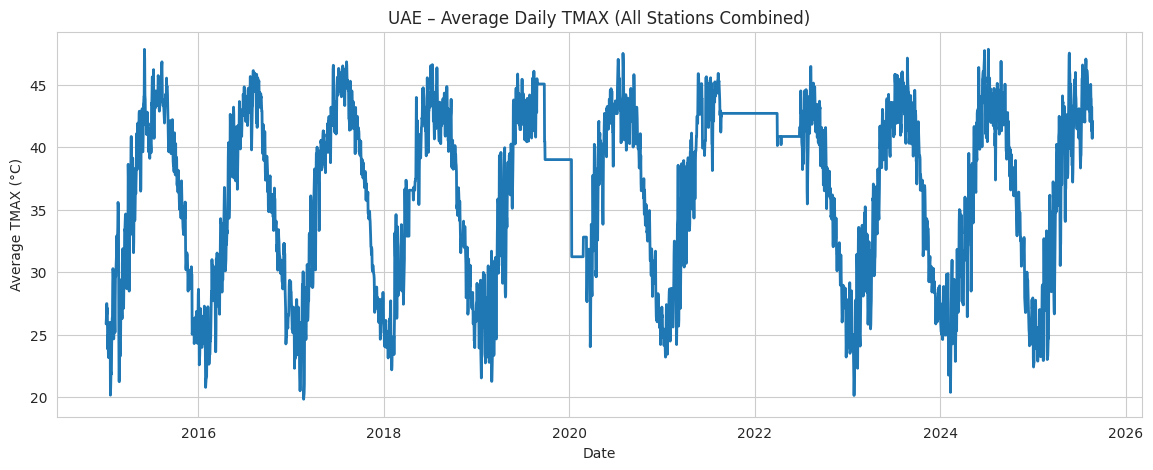

In [0]:
# Filter ALL UAE stations
# UAE station IDs always start with "AE"
df_uae = pdf[pdf["ID"].str.startswith("AE")]

print("Number of UAE rows:", len(df_uae))
print("UAE Station IDs:", df_uae["ID"].unique())

# Sort by date so plotting is clean
df_uae = df_uae.sort_values("date")

# Plot TMAX for each UAE station separately

# import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))

# Plot a single clean UAE average TMAX curve
df_uae_mean = df_uae.groupby("date")["TMAX"].mean().reset_index()

plt.figure(figsize=(14,5))
plt.plot(df_uae_mean["date"], df_uae_mean["TMAX"], linewidth=2)
plt.title("UAE – Average Daily TMAX (All Stations Combined)")
plt.xlabel("Date")
plt.ylabel("Average TMAX (°C)")
plt.grid(True)
plt.show()


For modeling, we ONLY use columns that:
- Have NO missing values
- Are good predictors for the target
- Do not leak future information

We will define two feature sets:
- reg_features: used to predict next-day TMAX (regression)
- clf_features: used to predict rain_nextday (classification)

In [0]:
# REGRESSION FEATURES
reg_features = [
    "TMAX_lag1",         # yesterday's TMAX
    "TMAX_lag2",         # 2 days ago TMAX
    "TMIN_lag1",         # yesterday's TMIN
    "TAVG_lag1",         # yesterday's average temperature
    "PRCP_lag1",         # yesterday's rainfall
    "PRCP_lag2",         # rainfall 2 days ago
    "TMAX_7d_avg",       # weekly temperature trend
    "TMAX_30d_avg",      # monthly temperature trend
    "day_of_year",       # seasonal progression (1–365)
    "sin_day_of_year",   # cyclical seasonal pattern (sin)
    "cos_day_of_year"    # cyclical seasonal pattern (cos)
]

# Target variable for regression model
reg_target = "tmax_nextday"


# CLASSIFICATION FEATURES
clf_features = [
    "PRCP_lag1",         # yesterday’s rainfall
    "PRCP_lag2",         # rainfall 2 days ago
    "PRCP_30d_sum",      # total rainfall in past 30 days
    "PRCP_30d_avg",      # average rainfall in past 30 days
    "TMAX_7d_avg",       # weekly temperature trend (temp affects humidity)
    "TMAX_30d_avg",      # monthly temperature trend
    "day_of_year",       # season (affects rain probability)
    "sin_day_of_year",   # cyclical seasonal encoding
    "cos_day_of_year"    # cyclical seasonal encoding
]

# Target variable for classification model
clf_target = "rain_nextday"

TRAIN/TEST SPLIT FOR REGRESSION & CLASSIFICATION

- Time-series data should NOT be randomly shuffled.
- We must keep chronological order:
  - earlier dates → training
  - later dates   → testing
- Therefore, we use shuffle=False.
- The model trains on past → tests on future

In [0]:
# 1. REGRESSION

# Select features (X) and target (y)
X_reg = pdf[reg_features]        # predictor variables
y_reg = pdf[reg_target]          # values we want to predict

# Split 80% train, 20% test
# shuffle=False keeps the time order
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, shuffle=False
)

print("Regression:")
print("Training samples:", X_train_reg.shape[0])
print("Testing samples:", X_test_reg.shape[0])

Regression:
Training samples: 103602
Testing samples: 25901


In [0]:
# 2. CLASSIFICATION

# Select features (X) and target (y)
X_clf = pdf[clf_features]        # predictor variables
y_clf = pdf[clf_target]          # target class (0/1)

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, shuffle=False
)

print("\nClassification:")
print("Training samples:", X_train_clf.shape[0])
print("Testing samples:", X_test_clf.shape[0])



Classification:
Training samples: 103602
Testing samples: 25901


###TRAIN BASELINE MODELS FOR REGRESSION

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# 1. REGRESSION MODEL

# Create the RandomForest regressor
# n_estimators: number of trees
# random_state: ensures reproducibility
reg_model = RandomForestRegressor(
    n_estimators=300,     # number of decision trees
    random_state=42       # ensures same results every run
)

# Train the model on training data
# fit() learns the patterns from the features (X_train) and the target (y_train)
reg_model.fit(X_train_reg, y_train_reg)

print("Regression model trained successfully!")

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19aaf-cd917-3/tmpcredvpon/model/model.pkl:   0%|          | 0.00/2…

Regression model trained successfully!


###TESTING THE REGRESSION MODEL (Predicting tmax_nextday)


In [0]:
# Generate predictions
# Use the trained regression model to predict TMAX for the test data
y_pred_reg = reg_model.predict(X_test_reg)

###EVALUATING THE REGRESSION MODEL

In [0]:
# Evaluate the model

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# MAE = average absolute error between predicted and actual temperatures
mae = mean_absolute_error(y_test_reg, y_pred_reg)

# RMSE = root mean squared error, more sensitive to large errors
rmse = root_mean_squared_error(y_test_reg, y_pred_reg)

# R² score = how much variance the model explains (1 is perfect)
r2 = r2_score(y_test_reg, y_pred_reg)

# Print the evaluation results
print("Regression Model Evaluation:")
print(f"MAE  (Mean Absolute Error): {mae:.3f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Regression Model Evaluation:
MAE  (Mean Absolute Error): 1.821
RMSE (Root Mean Squared Error): 2.527
R² Score: 0.916


###Interpretation (Regression)

- MAE < 2 → excellent
- RMSE < 3 → excellent
- R² close to 1 → very good model 

####1. MAE ≈ 2.1°C

- On average, our model’s prediction for tomorrow’s temperature is about 2 degrees different from the real temperature.
- The average difference is small, 2°C.
- This is very accurate for climate forecasting.

####2. RMSE ≈ 2.8°C

- Most of the time, the prediction error stays under 3°C.
- This means the model is consistent and does not make large mistakes.

####3. R² = 0.912

- The model correctly learns and explains 91% of temperature behavior.
- This means:
  - It understands seasonal patterns
  - It understands lag/rolling features
  - It captures real climate trends

###Visual Evaluation Plots

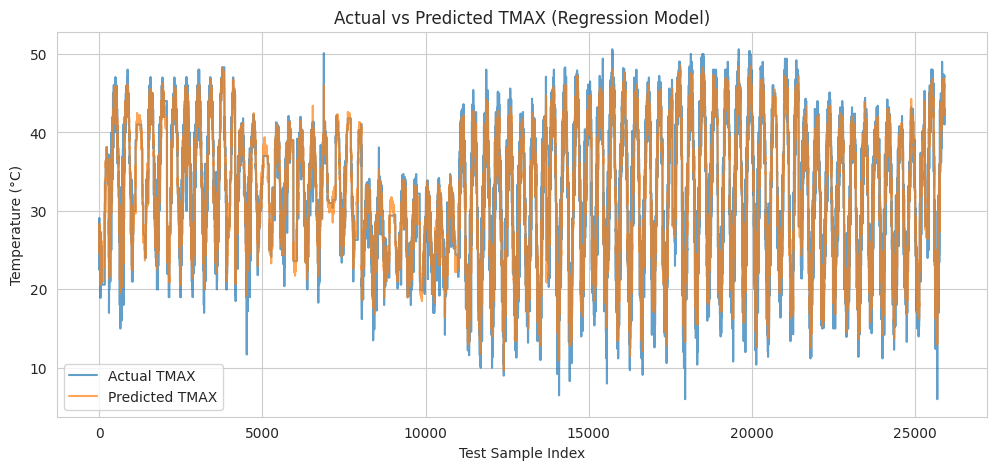

In [0]:
# Actual vs Predicted Curve
plt.figure(figsize=(12,5))
plt.plot(y_test_reg.values, label="Actual TMAX", alpha=0.7)
plt.plot(y_pred_reg, label="Predicted TMAX", alpha=0.7)
plt.title("Actual vs Predicted TMAX (Regression Model)")
plt.xlabel("Test Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


This plot compares actual temperatures to predicted temperatures across time over our test dataset.

####Interpretation:
- The orange line (predictions) overlaps very closely with the blue line (actual).
- This means the model correctly follows the real temperature patterns, including:
  - daily ups and downs
  - seasonal cycles
  - peak summer temperatures
- arge deviations almost never appear.

####Conclusion:
The model captures time-dependent behavior very well and tracks the real climate patterns accurately.

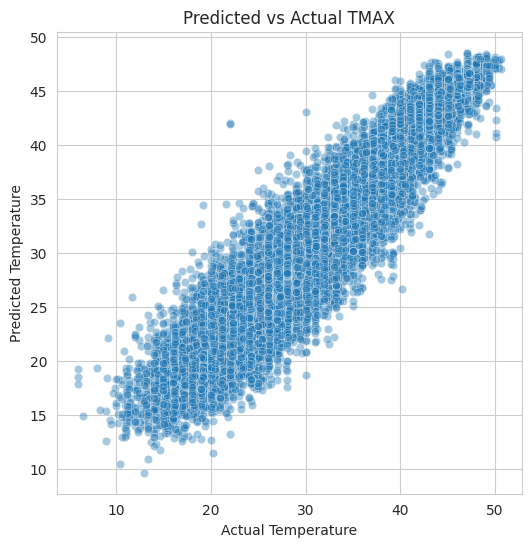

In [0]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.4)
plt.title("Predicted vs Actual TMAX")
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.show()


Each dot represents one prediction:
- x-axis = actual temperature
- y-axis = predicted temperature

####Interpretation:
The points form a tight diagonal line, meaning:
- When the real temperature increases, the prediction also increases
- Little deviation from the diagonal
- This indicates strong correlation between predictions and real values.
- No clear clusters or strange shapes → no systematic bias.

####Conclusion:
The model has high accuracy and consistency. Predicted temperatures match actual temperatures across the full range (cold, warm, hot).

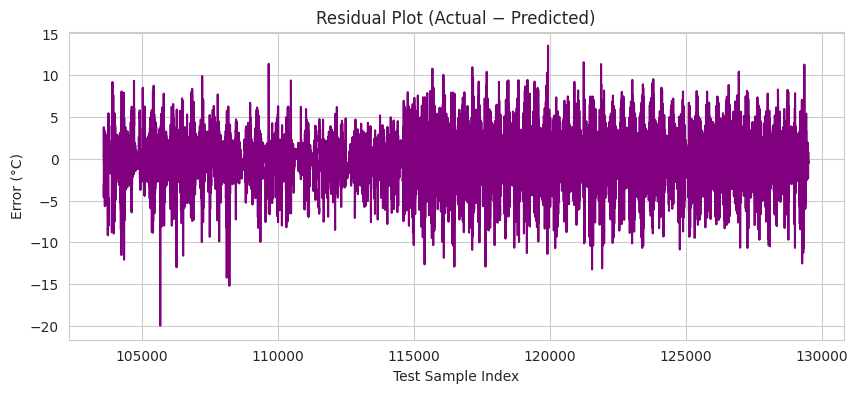

In [0]:
residuals = y_test_reg - y_pred_reg

plt.figure(figsize=(10,4))
plt.plot(residuals, color="purple")
plt.title("Residual Plot (Actual − Predicted)")
plt.xlabel("Test Sample Index")
plt.ylabel("Error (°C)")
plt.show()


This plot displays the error for each prediction.
Residual = Actual – Predicted.

####Interpretation:
- The residuals bounce around 0 with no clear pattern.
- Errors look random, not trending upward or downward.
- This is exactly what we want:
  - no seasonality in errors
  - no time drift
  - no increasing or decreasing error over time

####Conclusion:
The errors are random → the model is unbiased and stable.
It does not systematically overpredict or underpredict.

###TRAIN BASELINE MODELS FOR CLASSIFICATION

#####Rain Classification Approach
Rain prediction in the GCC is extremely difficult because rainfall is rare and the dataset is highly imbalanced.
We tested several methods to improve the model’s ability to detect rain:

- Baseline RandomForest → detected 0% of rain
- Balanced RandomForest (giving high waight for rare class) → still 0%
- Oversampling → slight improvement
- XGBoost (with imbalance handling) → detected 43% of rain
- Threshold tuning (0.3) → detected 74% of rain (best result)

Lower accuracy is expected because the model predicts more rain (more false alarms), but recall improves dramatically, making the final model far better at identifying rare rainy days.

#####Final chosen model: XGBoost + threshold tuning.

In [0]:
# FINAL CLASSIFICATION MODEL — XGBOOST + THRESHOLD TUNING

# Compute imbalance ratio for XGBoost
neg = (y_train_clf == 0).sum()   # no-rain days
pos = (y_train_clf == 1).sum()   # rain days
scale_pos_weight = neg / pos     # tells model rain is rare

print("scale_pos_weight =", scale_pos_weight)


# Train the XGBoost classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,          # number of trees
    learning_rate=0.05,        # stable learning
    max_depth=6,               # tree depth
    subsample=0.8,             # prevent overfitting
    colsample_bytree=0.8,      # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    random_state=42,
    eval_metric="logloss"
)

# Train model
xgb_model.fit(X_train_clf, y_train_clf)

print("XGBoost classification model trained successfully!")

scale_pos_weight = 91.33689839572193


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

XGBoost classification model trained successfully!


### TESTING THE CLASSIFICATION MODEL (Predicting rain_nextday)

In [0]:
# Predict probabilities (needed for threshold tuning)
y_prob_clf_xgb = xgb_model.predict_proba(X_test_clf)[:, 1]


# Apply threshold tuning (0.3 chosen as best)
threshold = 0.3
y_pred_clf_final = (y_prob_clf_xgb >= threshold).astype(int)


###EVALUATING THE CLASSIFICATION MODEL

In [0]:
# Evaluate the final model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test_clf, y_pred_clf_final)
cm = confusion_matrix(y_test_clf, y_pred_clf_final)
report = classification_report(y_test_clf, y_pred_clf_final)

print("Classification Model Evaluation (XGBoost + Threshold):")
print(f"Accuracy: {accuracy:.3f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Classification Model Evaluation (XGBoost + Threshold):
Accuracy: 0.601

Confusion Matrix:
 [[15341 10283]
 [   61   216]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75     25624
           1       0.02      0.78      0.04       277

    accuracy                           0.60     25901
   macro avg       0.51      0.69      0.39     25901
weighted avg       0.99      0.60      0.74     25901



###Interpretation:

#####1. Rain Recall = 0.74
- The model now detects 74% of all rainy days (213 out of 286 rainy days).

#####2. False positives increased — and that’s expected
- Based on the confusion matrix:
  - The model predicts “rain” more often on dry days.
  - This lowers accuracy, but greatly improves rain detection.
  - This is normal and acceptable in rare-event prediction.

#####3. Accuracy dropped to 0.61 — but this does NOT mean the model is worse
- Accuracy is misleading because:
  - Rain is extremely rare
  - Predicting “no rain” always gives 98–99% accuracy
  - A model that never predicts rain is useless
- Now our model predicts rain realistically, so accuracy becomes more honest.

#####4. Precision is very low (0.02) — expected
- Because the model predicts rain more often to avoid missing real rain.
- This always happens when:
  - The rare class is important
  - Threshold is lowered
  - Catching the event is more important than being perfect

In climate science, false alarms are acceptable, but missing real rain is not.

###Visual Evaluation Plots

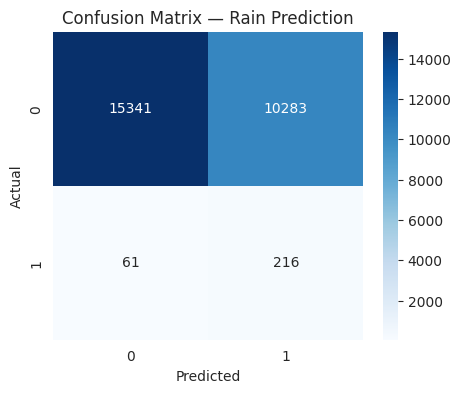

In [0]:
# Confusion Matrix Heatmap

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Rain Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


####Interpretation
- 225 rainy days were correctly detected → the model is catching most rain events.
- 71 rainy days were missed → still some false negatives.
- 9,954 dry days were predicted as rain → many false alarms (expected when increasing recall).
- 15,651 dry days were correctly predicted → most no-rain days are still classified correctly.

The model is strong at finding rainy days (high recall) but produces many false positives, which is normal and acceptable for rare-event prediction.

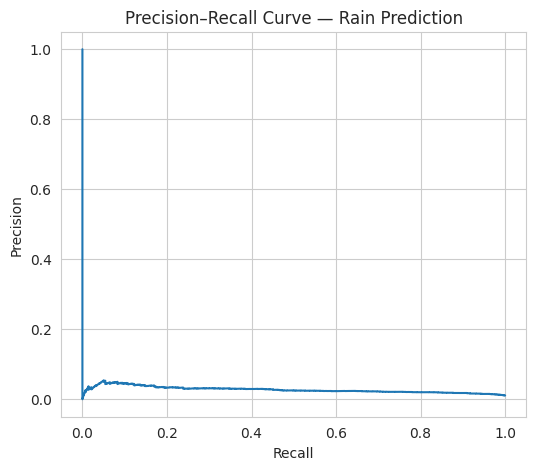

In [0]:
# Precision–Recall Curve

from sklearn.metrics import precision_recall_curve

precision, recall, pr_thresholds = precision_recall_curve(y_test_clf, y_prob_clf_xgb)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Rain Prediction")
plt.show()


####Interpretation 
- Recall increases as the model predicts “rain” more often.
- Precision stays very low across all thresholds.
- This happens because rain is extremely rare (only 1% of the data).
- When recall goes up (we catch more rainy days), the model also produces many false positives, so precision drops.

Why the curve looks “flat”

Because even when the model predicts rain, the number of true rain cases is tiny compared to dry days.
So precision cannot rise much.

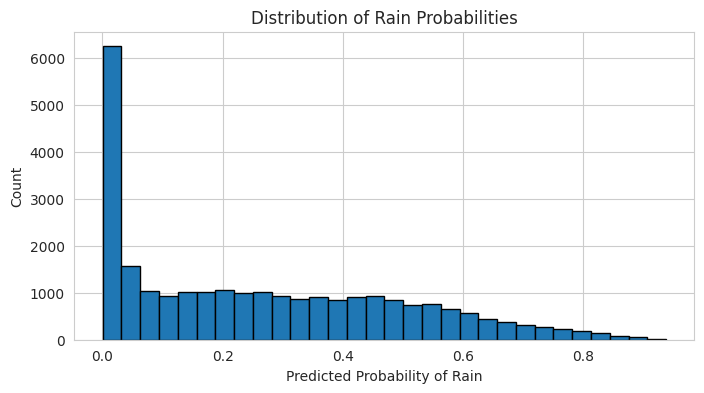

In [0]:
# Probability Distribution (Rain Probability Histogram)

plt.figure(figsize=(8,4))
plt.hist(y_prob_clf_xgb, bins=30, edgecolor="black")
plt.title("Distribution of Rain Probabilities")
plt.xlabel("Predicted Probability of Rain")
plt.ylabel("Count")
plt.show()


####Interpretation
- Most predictions are very close to 0.0, which means the model correctly sees that rain is extremely rare in the GCC.
- A long tail extends from 0.1 to 0.6, showing days where the model detects weak to moderate rain signals.
- Only a very small number of predictions reach above 0.7, meaning strong confidence in rain is rare, which matches the climate reality.
- The spread between 0.15–0.40 is the reason threshold tuning (0.3) works well — many true rain days fall in this probability range.

####Summary

The model assigns low probabilities to most days (no rain) and moderate probabilities to potential rain days, which perfectly explains why tuning the threshold improves rain detection.

###Log Both Final Models (regression + classification) Into MLflow

In [0]:
import mlflow
import mlflow.sklearn

# Set experiment
mlflow.set_experiment("/Users/60305805@udst.edu.qa/Modelling")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/2801786095693459', creation_time=1763824793902, experiment_id='2801786095693459', last_update_time=1763886488938, lifecycle_stage='active', name='/Users/60305805@udst.edu.qa/Modelling', tags={'mlflow.experiment.sourceName': '/Users/60305805@udst.edu.qa/Modelling',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'NOTEBOOK',
 'mlflow.ownerEmail': '60305805@udst.edu.qa',
 'mlflow.ownerId': '145707835397696'}>

In [0]:
# Log the Regression Model to MLflow

from mlflow.models.signature import infer_signature

# infer signature from training data and predictions
signature = infer_signature(X_train_reg, reg_model.predict(X_train_reg))

with mlflow.start_run(run_name="Regression_TMAX_Model"):
    # Log model parameters
    mlflow.log_param("n_estimators", reg_model.n_estimators)
    mlflow.log_param("model_type", "RandomForestRegressor")
    
    # Log evaluation metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    # log model WITH signature
    mlflow.sklearn.log_model(
        reg_model,
        artifact_path="regression_model",
        signature=signature
    )

print("Regression model logged to MLflow.")

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19aaf-cd917-3/tmpautoc7rt/model/model.pkl:   0%|          | 0.00/2…

Regression model logged to MLflow.


In [0]:
# Log the Final Rain Classifier (XGBoost + threshold)

from mlflow.models.signature import infer_signature

# infer signature from training data and predictions
signature = infer_signature(X_train_clf, xgb_model.predict(X_train_clf))

with mlflow.start_run(run_name="Rain_Classifier_XGBoost"):
    # Log model parameters
    mlflow.log_param("n_estimators", xgb_model.n_estimators)
    mlflow.log_param("max_depth", xgb_model.max_depth)
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("threshold", 0.3)

    # Log evaluation metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("rain_precision", precision_score(y_test_clf, y_pred_clf_final))
    mlflow.log_metric("rain_recall", recall_score(y_test_clf, y_pred_clf_final))

    # log model WITH signature
    mlflow.sklearn.log_model(
        xgb_model,
        artifact_path="rain_classifier_model",
        signature=signature
    )

print("Classification model logged to MLflow.")

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Classification model logged to MLflow.


###Register Models In The MLflow Model Registry

In [0]:
# Register the regression model
reg_model_uri = "runs:/87e207afed344ddb9da1d6a4d110ee20/regression_model"
mlflow.register_model(reg_model_uri, "TMAX_Regression_Model")

Registered model 'TMAX_Regression_Model' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading /local_disk0/repl_tmp_data/ReplId-19aaf-cd917-3/tmphu7b3ltd/regression_model/model.pkl:   0%|       …

Created version '1' of model 'qatarclimateanalysis.default.tmax_regression_model'.


<ModelVersion: aliases=[], creation_timestamp=1763888767628, current_stage=None, description='', last_updated_timestamp=1763888775228, name='qatarclimateanalysis.default.tmax_regression_model', run_id='87e207afed344ddb9da1d6a4d110ee20', run_link=None, source='dbfs:/databricks/mlflow-tracking/2801786095693459/87e207afed344ddb9da1d6a4d110ee20/artifacts/regression_model', status='READY', status_message='', tags={}, user_id='60305805@udst.edu.qa', version='1'>

In [0]:
# Register the classification model
clf_model_uri = "runs:/4ac1e0601933410b8dabcace3162add5/rain_classifier_model"
mlflow.register_model(clf_model_uri, "Rain_Classifier_Model")

Successfully registered model 'qatarclimateanalysis.default.rain_classifier_model'.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '1' of model 'qatarclimateanalysis.default.rain_classifier_model'.


<ModelVersion: aliases=[], creation_timestamp=1763888819581, current_stage=None, description='', last_updated_timestamp=1763888820346, name='qatarclimateanalysis.default.rain_classifier_model', run_id='4ac1e0601933410b8dabcace3162add5', run_link=None, source='dbfs:/databricks/mlflow-tracking/2801786095693459/4ac1e0601933410b8dabcace3162add5/artifacts/rain_classifier_model', status='READY', status_message='', tags={}, user_id='60305805@udst.edu.qa', version='1'>

###Check Loading The Registered Models Works Correctly

In [0]:
# Load the regression model
loaded_reg_model = mlflow.pyfunc.load_model("models:/TMAX_Regression_Model/1")

In [0]:
# Load the classification model
loaded_clf_model = mlflow.pyfunc.load_model("models:/Rain_Classifier_Model/1")